<div style="background-color:#3b5998; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>MALICIOUS URL DETECTION SYSTEM 🛡️💙 </b></h1>
</div>

<div style="background-color:#ffffff; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <img src="https://media.tenor.com/glJTnrs3k4AAAAAC/virus-glitch.gif" alt="Animated GIF">
</div>

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>IMPORT DEPENDENCIES</b></h2>
</div>

In [1]:
!pip3 install -U -q scikit-learn joblib seaborn colorama tld plotly whois wordcloud gensim nltk tldextract hmmlearn xgboost lightgbm catboost

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import re
import string
import nltk
import tldextract
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
import logging
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import whois
from sklearn.pipeline import Pipeline
from datetime import datetime
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier, Perceptron, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
urls_data = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>DATA PREPROCESSING AND EDA</b></h2>
</div>

In [4]:
urls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
urls_data.isnull().sum()

url     0
type    0
dtype: int64

In [6]:
count = urls_data['type'].value_counts()
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D'
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

In [7]:
urls_data['url'] = urls_data['url'].replace('www.', '', regex=True)
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [8]:
urls_data["type"].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [9]:
urls_data["url_type"] = urls_data["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

In [10]:
urls_data.head()

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [11]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

In [12]:
urls_data['url_len'] = urls_data['url'].apply(lambda x: get_url_length(str(x)))

In [13]:
urls_data.head()

,url,type,url_type,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228


In [14]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [15]:
urls_data['pri_domain'] = urls_data['url'].apply(lambda x: extract_pri_domain(x))

In [16]:
urls_data.head()

,url,type,url_type,url_len,pri_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net


In [17]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [18]:
urls_data['letters_count']        = urls_data['url'].apply(lambda x: count_letters(x))
urls_data['digits_count']         = urls_data['url'].apply(lambda x: count_digits(x))
urls_data['special_chars_count']  = urls_data['url'].apply(lambda x: count_special_chars(x))

In [19]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14


In [20]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

In [21]:
urls_data['shortened']  = urls_data['url'].apply(lambda x: has_shortening_service(x))

In [22]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0


In [23]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

In [24]:
urls_data['abnormal_url']  = urls_data['url'].apply(lambda x: abnormal_url(x))

In [25]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1


In [26]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

In [27]:
urls_data['secure_http']  = urls_data['url'].apply(lambda x: secure_http(x))

In [28]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0


In [29]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

In [30]:
urls_data['have_ip']  = urls_data['url'].apply(lambda x: have_ip_address(x))

In [31]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0


In [32]:
urls_data.isnull().sum()

url                        0
type                       0
url_type                   0
url_len                    0
pri_domain             12223
letters_count              0
digits_count               0
special_chars_count        0
shortened                  0
abnormal_url               0
secure_http                0
have_ip                    0
dtype: int64

In [33]:
urls_data.fillna(0,inplace=True)

In [34]:
urls_data.isnull().sum()

url                    0
type                   0
url_type               0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
dtype: int64

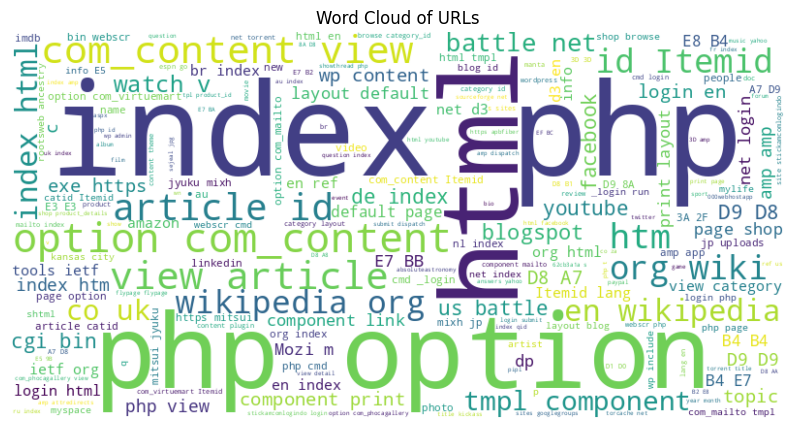

In [35]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(urls_data['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [36]:
# Histogram
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x=urls_data['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='plotly_dark',
    font=dict(color='white')
)

fig.show()

In [37]:
# Bar chart for 'type' column
type_counts = urls_data['type'].value_counts()
fig = go.Figure(data=[go.Bar(x=type_counts.index, y=type_counts.values)])
fig.update_layout(title='Frequency of URL Types',
                  xaxis_title='URL Type',
                  yaxis_title='Count',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=False)
fig.show()

In [38]:
# Pie chart for 'url_type' column
url_type_counts = urls_data['url_type'].value_counts()
fig = go.Figure(data=[go.Pie(labels=url_type_counts.index, values=url_type_counts.values)])
fig.update_layout(title='Distribution of URL Types',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=True)
fig.show()

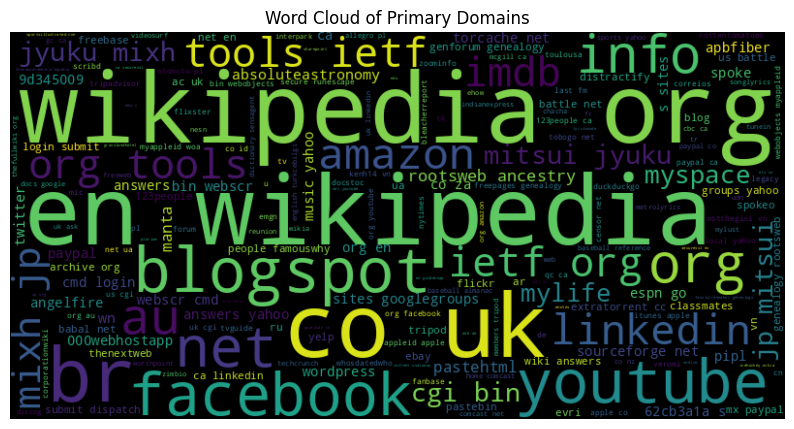

In [39]:
# Convert pri_domain values to strings and filter out None and int values
filtered_domains = urls_data['pri_domain'].map(str).dropna()

# Concatenate all pri_domain values into a single string
text = ' '.join(filtered_domains)

# Generate the WordCloud data
wordcloud = WordCloud(background_color='black', colormap='viridis', width=800, height=400).generate(text)

# Plot the WordCloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Primary Domains', color='black')
plt.show()

In [40]:
counts = urls_data[['letters_count', 'digits_count', 'special_chars_count']].sum()

fig = go.Figure(data=[
    go.Bar(name='Letters', x=['Count'], y=[counts['letters_count']]),
    go.Bar(name='Digits', x=['Count'], y=[counts['digits_count']]),
    go.Bar(name='Special Characters', x=['Count'], y=[counts['special_chars_count']])
])

fig.update_layout(title='Counts of Letters, Digits, and Special Characters',
                  xaxis_title='Type',
                  yaxis_title='Count',
                  barmode='group',
                  template='plotly_dark',
                  font=dict(color='white'))

fig.show()

In [41]:
true_color = 'green'

false_color = 'red'

shortened_counts = urls_data['shortened'].value_counts()
colors = [true_color if val else false_color for val in shortened_counts.index]
fig_shortened = go.Figure(data=go.Bar(x=shortened_counts.index, y=shortened_counts, marker_color=colors))
fig_shortened.update_layout(title='Counts of shortened',
                            xaxis_title='Value',
                            yaxis_title='Count',
                            template='plotly_dark',
                            font=dict(color='white'))
fig_shortened.show()

abnormal_url_counts = urls_data['abnormal_url'].value_counts()
colors = [true_color if val else false_color for val in abnormal_url_counts.index]
fig_abnormal_url = go.Figure(data=go.Bar(x=abnormal_url_counts.index, y=abnormal_url_counts, marker_color=colors))
fig_abnormal_url.update_layout(title='Counts of abnormal_url',
                               xaxis_title='Value',
                               yaxis_title='Count',
                               template='plotly_dark',
                               font=dict(color='white'))
fig_abnormal_url.show()

secure_http_counts = urls_data['secure_http'].value_counts()
colors = [true_color if val else false_color for val in secure_http_counts.index]
fig_secure_http = go.Figure(data=go.Bar(x=secure_http_counts.index, y=secure_http_counts, marker_color=colors))
fig_secure_http.update_layout(title='Counts of secure_http',
                              xaxis_title='Value',
                              yaxis_title='Count',
                              template='plotly_dark',
                              font=dict(color='white'))
fig_secure_http.show()

have_ip_counts = urls_data['have_ip'].value_counts()
colors = [true_color if val else false_color for val in have_ip_counts.index]
fig_have_ip = go.Figure(data=go.Bar(x=have_ip_counts.index, y=have_ip_counts, marker_color=colors))
fig_have_ip.update_layout(title='Counts of have_ip',
                          xaxis_title='Value',
                          yaxis_title='Count',
                          template='plotly_dark',
                          font=dict(color='white'))
fig_have_ip.show()

In [42]:
numeric_data = urls_data.select_dtypes(include='number')

corr_matrix = numeric_data.corr()

heatmap = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Greys',  
)


layout = go.Layout(
    title='Correlation Heatmap (Numeric Values Only)',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    plot_bgcolor='black', 
    paper_bgcolor='black', 
    font=dict(color='white')  
)


fig = go.Figure(data=heatmap, layout=layout)


fig.show()

In [43]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0


In [44]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

In [45]:
urls_data['url_region'] = urls_data['pri_domain'].apply(lambda x: get_url_region(str(x)))

In [46]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global


In [47]:
region_counts = urls_data['url_region'].value_counts()

if 'Global' not in region_counts.index:
    region_counts['Global'] = 0

data = pd.DataFrame({'region': region_counts.index, 'count': region_counts.values})

colorscale = 'YlOrRd'  

fig = go.Figure(data=go.Choropleth(
    locations=data['region'],
    z=data['count'],
    locationmode='country names',
    colorscale=colorscale,
    autocolorscale=True,  
    marker_line_color='white',
    colorbar_title='Count'
))


fig.update_layout(title_text='Distribution of URL Regions')

fig.show()

In [48]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [49]:
urls_data['root_domain'] = urls_data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [50]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [51]:
urls_data.isnull().sum()

url                    0
type                   0
url_type               0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [52]:
urls_data.shape

(651191, 14)

In [53]:
urls_data.duplicated().sum()

11081

In [54]:
urls_data.drop_duplicates(inplace=True)

In [55]:
urls_data.columns

Index(['url', 'type', 'url_type', 'url_len', 'pri_domain', 'letters_count',
       'digits_count', 'special_chars_count', 'shortened', 'abnormal_url',
       'secure_http', 'have_ip', 'url_region', 'root_domain'],
      dtype='object')

In [56]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [57]:
data = urls_data.drop(columns=['url','type','pri_domain'])
data.head()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,Brazil,br-icloud
1,0,35,29,1,5,0,0,0,0,Global,mp3raid
2,0,31,25,1,5,0,0,0,0,Global,bopsecrets
3,1,77,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,1,228,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [58]:
data['root_domain'].value_counts()

root_domain
wikipedia                  13426
0                          12224
youtube                     8639
blogspot                    8468
facebook                    8362
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: count, Length: 147572, dtype: int64

In [59]:
data = data[data['root_domain'] != '0']

In [60]:
data['root_domain'].value_counts()

root_domain
wikipedia                  13426
youtube                     8639
blogspot                    8468
facebook                    8362
yahoo                       5843
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: count, Length: 147571, dtype: int64

In [61]:
len(data['root_domain'].value_counts())

147571

In [62]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [63]:
data['root_domain'] = data['root_domain'].apply(hash_encode)

In [64]:
data['url_region'] = data['url_region'].apply(hash_encode)

In [65]:
data.head()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,27739261,1310791
1,0,35,29,1,5,0,0,0,0,32604616,58335668
2,0,31,25,1,5,0,0,0,0,32604616,28611805
3,1,77,60,7,17,0,1,0,0,71484583,89045308
4,1,228,199,22,14,0,1,0,0,32604616,76838614


In [66]:
data.shape

(627886, 11)

In [67]:
data.isnull().sum()

url_type               0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [68]:
data.columns

Index(['url_type', 'url_len', 'letters_count', 'digits_count',
       'special_chars_count', 'shortened', 'abnormal_url', 'secure_http',
       'have_ip', 'url_region', 'root_domain'],
      dtype='object')

In [69]:
x = data.drop(columns=['url_type'])
y = data['url_type']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>MODEL DEVELOPMENT</b></h2>
</div>

In [70]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (439520, 10)
Y_train Shape : (439520,)
X_test  Shape : (188366, 10)
Y_test  Shape : (188366,)


In [71]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    ExtraTreesClassifier(),
    GaussianNB()
]

In [72]:
results = []
for classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    scores = cross_val_score(pipeline, x, y, cv=2, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=2)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1) 
    f1 = f1_score(y, y_pred, average='weighted')
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))

In [73]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results.head()

,Classifier,Accuracy,Recall,Precision,F1-Score
4,ExtraTreesClassifier,0.804775,0.804775,0.734339,0.763177
1,RandomForestClassifier,0.804498,0.804498,0.734101,0.762871
0,DecisionTreeClassifier,0.798201,0.798201,0.743762,0.766304
2,AdaBoostClassifier,0.786851,0.786851,0.692477,0.732505
3,KNeighborsClassifier,0.785338,0.785338,0.740679,0.756246


In [74]:
pipeline = Pipeline([
        ('classifier', ExtraTreesClassifier())
    ])
pipeline.fit(x_train,y_train)

Pipeline(steps=[('classifier', ExtraTreesClassifier())])

In [75]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94    128308
           1       0.92      0.97      0.94     28491
           2       0.69      0.61      0.65     28058
           3       0.88      0.75      0.81      3509

    accuracy                           0.90    188366
   macro avg       0.86      0.82      0.84    188366
weighted avg       0.89      0.90      0.89    188366



In [76]:
import joblib
joblib.dump(pipeline,'saved_model.sav')

['saved_model.sav']

<div style="background-color:#dfe3ee; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>MODEL RESULTS</b></h2>
</div>


In [77]:
fig = go.Figure(data=go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                fill_color='black',
                font=dict(color='white'),
                align='center'),
    cells=dict(values=[results['Classifier'], results['Accuracy'], results['Precision'],
                       results['Recall'], results['F1-Score']],
               fill_color='black',
               font=dict(color='white'),
               align='center')))

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'))

fig.show()

In [78]:
for column in results.columns:
    fig = go.Figure(data=go.Bar(
        x=results['Classifier'],
        y=results[column],
        marker=dict(color='steelblue'),
        text=results[column],
        textposition='auto'
    ))

    fig.update_layout(
        title_text=column,
        xaxis_title='Model',
        yaxis_title=column,
        plot_bgcolor='rgb(17,17,17)',  
        paper_bgcolor='rgb(17,17,17)',
        font=dict(color='white') 
    )


    fig.show()

In [79]:
def get_numerical_values(url):
    url = url.replace('www.', '')
    url_len = get_url_length(url)
    letters_count = count_letters(url)
    digits_count  = count_digits(url)
    special_chars_count = count_special_chars(url)
    shortened = has_shortening_service(url)
    abnormal = abnormal_url(url)
    secure_https = secure_http(url)
    have_ip = have_ip_address(url)
    
    parsed_url  = urlparse(url)
    root_domain = parsed_url.netloc.split(".")[-2]
    url_region = get_url_region(root_domain)
    
    return {
        'url_len': url_len,
        'letters_count': letters_count,
        'digits_count': digits_count,
        'special_chars_count': special_chars_count,
        'shortened': shortened,
        'abnormal': abnormal,
        'secure_http': secure_https,
        'have_ip': have_ip,
        'url_region': hash_encode(url_region),
        'root_domain': hash_encode(root_domain)
    }

def get_url_length(url):
    return len(url)
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))
def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0
def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [80]:
url = "https://www.example.com"
numerical_values = get_numerical_values(url)
print(len(numerical_values))

10
